In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import statsmodels.api as sm

In [2]:
# --- 2. Define Paths and Load Datasets (Corrected) ---
PROJECT_ROOT = Path("../")
PROCESSED_DATA_DIR = PROJECT_ROOT / "data" / "processed"
FLOW_DATA_DIR = PROJECT_ROOT / "data" / "flow"

# Input file paths
CLIMATE_CSV = PROCESSED_DATA_DIR / "chittenden_basin_daily_averages.csv"
FLOW_CSV = FLOW_DATA_DIR / "flow.csv"

# --- FIX IS HERE: More robust loading for the climate data ---
try:
    # Load the data, specifying the first column as the index and parsing its dates.
    climate_df = pd.read_csv(CLIMATE_CSV, index_col=0, parse_dates=True)
    climate_df.index.name = 'Date' # Rename the index for clarity
    
    # Ensure the index is a DatetimeIndex
    if not isinstance(climate_df.index, pd.DatetimeIndex):
        raise TypeError("Climate DataFrame index was not converted to DatetimeIndex.")
    
    print("Climate data loaded successfully:")
    print(climate_df.head())
    print("\nClimate index data type:", climate_df.index.dtype)

except FileNotFoundError:
    print(f"ERROR: Climate data not found at {CLIMATE_CSV}")
except Exception as e:
    print(f"An error occurred loading climate data: {e}")

# Load the discharge (flow) data (this part was likely correct already)
try:
    flow_df = pd.read_csv(FLOW_CSV, parse_dates=['Date'], index_col='Date')
    print("\nFlow data loaded successfully:")
    print(flow_df.head())
    print("\nFlow index data type:", flow_df.index.dtype)
except FileNotFoundError:
    print(f"ERROR: Flow data not found at {FLOW_CSV}")
except Exception as e:
    print(f"An error occurred loading flow data: {e}")

Climate data loaded successfully:
                  pr    tasmax    tasmin
Date                                    
1953-12-12  8.183246  4.431120 -3.860412
1953-12-13  1.661795  0.860373 -7.303835
1953-12-14  5.710673  2.247344 -5.375595
1953-12-15  0.000000 -0.943555 -8.745102
1953-12-16  0.000000  1.311886 -5.434699

Climate index data type: datetime64[ns]

Flow data loaded successfully:
            Discharge
Date                 
1953-12-12       28.9
1953-12-13        NaN
1953-12-14        NaN
1953-12-15       27.3
1953-12-16       25.3

Flow index data type: datetime64[ns]


In [3]:
# --- 3. Clean and Merge DataFrames ---

# First, ensure the 'Discharge' column is numeric. `errors='coerce'` will turn
# any non-numeric values (like the blanks in your example) into NaN (Not a Number).
flow_df['Discharge'] = pd.to_numeric(flow_df['Discharge'], errors='coerce')

# Now, drop any rows that have a NaN value in the 'Discharge' column.
# We can't do analysis on days with no flow data.
flow_df.dropna(subset=['Discharge'], inplace=True)
print(f"\nCleaned flow data. Number of valid observations: {len(flow_df)}")

# Combine the two dataframes using an 'inner' join.
# This aligns them by date and only keeps dates where we have BOTH climate and flow data.
combined_df = climate_df.join(flow_df, how='inner')

print("\n--- Combined and Aligned DataFrame ---")
print(combined_df.head())
print("\n--- Data Info ---")
combined_df.info()


Cleaned flow data. Number of valid observations: 287

--- Combined and Aligned DataFrame ---
                  pr    tasmax    tasmin  Discharge
Date                                               
1953-12-12  8.183246  4.431120 -3.860412       28.9
1953-12-15  0.000000 -0.943555 -8.745102       27.3
1953-12-16  0.000000  1.311886 -5.434699       25.3
1953-12-17  0.085418  0.753608 -6.014120       24.6
1953-12-18  9.833351  1.316915 -3.681000       23.9

--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 287 entries, 1953-12-12 to 1954-09-30
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pr         287 non-null    float64
 1   tasmax     287 non-null    float64
 2   tasmin     287 non-null    float64
 3   Discharge  287 non-null    float64
dtypes: float64(4)
memory usage: 11.2 KB


In [4]:
# --- 4. Create Lagged Climate Variables (1 to 7 Days) ---

# It's good practice to work on a copy
analysis_df = combined_df.copy()

# --- NEW: Use a loop to create all lags from 1 to 7 days ---

# List of columns to apply the lag to
variables_to_lag = ['pr', 'tasmax', 'tasmin']
# Number of lag days to create
num_days = 7

print(f"Generating lagged features for {num_days} days...")

# Loop from 1 to 7 (the +1 is because Python's range is exclusive of the end)
for day in range(1, num_days + 1):
    # For each day, create a lagged version of each climate variable
    for var in variables_to_lag:
        # Create a new, descriptive column name, e.g., 'pr_lag1', 'pr_lag2', etc.
        new_col_name = f"{var}_lag{day}"
        analysis_df[new_col_name] = analysis_df[var].shift(day)

# Shifting creates NaN values at the beginning of the DataFrame.
# The number of NaNs is equal to the longest lag period (7 days).
# It's best to drop these rows before any analysis.
analysis_df.dropna(inplace=True)

print("\n--- DataFrame with Lagged Features (showing first few valid rows) ---")
# Use .iloc to show the top, as head() would just be the first dates.
# The .columns property is useful to see all the new columns we created.
print(f"DataFrame shape: {analysis_df.shape}")
print(f"Columns: {analysis_df.columns.tolist()}")
print(analysis_df.head())

Generating lagged features for 7 days...

--- DataFrame with Lagged Features (showing first few valid rows) ---
DataFrame shape: (280, 25)
Columns: ['pr', 'tasmax', 'tasmin', 'Discharge', 'pr_lag1', 'tasmax_lag1', 'tasmin_lag1', 'pr_lag2', 'tasmax_lag2', 'tasmin_lag2', 'pr_lag3', 'tasmax_lag3', 'tasmin_lag3', 'pr_lag4', 'tasmax_lag4', 'tasmin_lag4', 'pr_lag5', 'tasmax_lag5', 'tasmin_lag5', 'pr_lag6', 'tasmax_lag6', 'tasmin_lag6', 'pr_lag7', 'tasmax_lag7', 'tasmin_lag7']
                  pr    tasmax    tasmin  Discharge    pr_lag1  tasmax_lag1  \
Date                                                                          
1953-12-21  1.856441  0.110564 -5.650301       24.6  13.529696     2.376250   
1953-12-22  0.000000 -1.409292 -8.135473       25.2   1.856441     0.110564   
1953-12-23  3.224922 -1.538931 -8.760681       25.9   0.000000    -1.409292   
1953-12-24  5.404879 -0.098470 -8.078240       25.1   3.224922    -1.538931   
1953-12-25  7.966689  0.721236 -3.533589       24.8


--- Correlation of Each Variable with Discharge (Sorted) ---
             Discharge
tasmax_lag2   0.580172
tasmax_lag3   0.576665
tasmax_lag1   0.568014
tasmax_lag4   0.561784
tasmax        0.550308
tasmax_lag5   0.548467
tasmax_lag6   0.539161
tasmax_lag7   0.531732
tasmin_lag1   0.515610
tasmin        0.512869
tasmin_lag2   0.508205
tasmin_lag3   0.495277
tasmin_lag4   0.484382
tasmin_lag5   0.477050
tasmin_lag6   0.470662
tasmin_lag7   0.463465
pr           -0.194542
pr_lag6      -0.198687
pr_lag1      -0.199901
pr_lag7      -0.203569
pr_lag5      -0.209558
pr_lag2      -0.214711
pr_lag4      -0.217156
pr_lag3      -0.223502


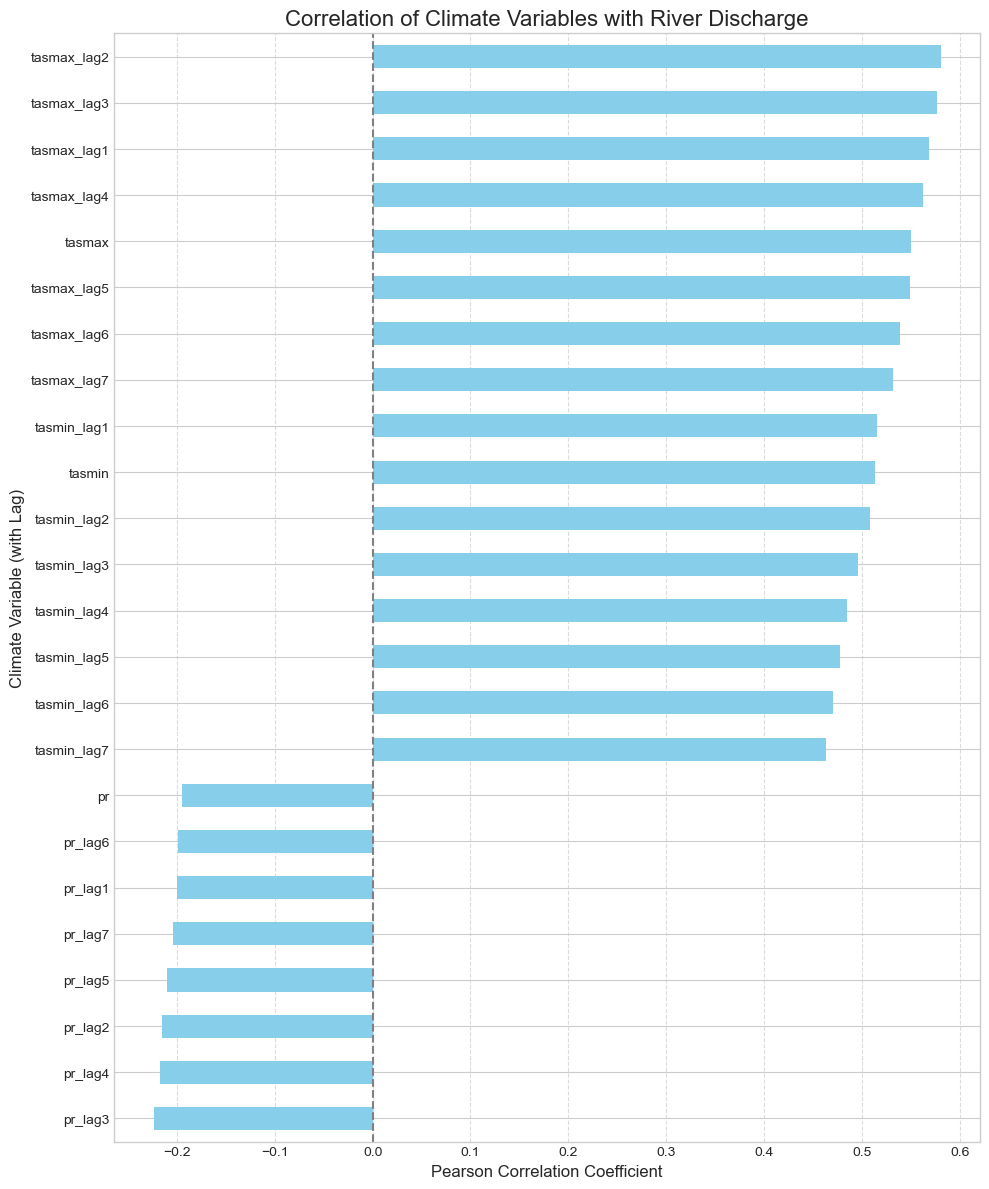

In [5]:
# --- 5. Focused Correlation Analysis on Discharge ---

# Calculate the full correlation matrix
corr_matrix = analysis_df.corr()

# Isolate ONLY the correlations with the 'Discharge' column
discharge_corr = corr_matrix[['Discharge']].sort_values(by='Discharge', ascending=False)

# Drop the self-correlation (Discharge vs. Discharge) which is always 1.0 and just adds noise
discharge_corr = discharge_corr.drop('Discharge')

print("\n--- Correlation of Each Variable with Discharge (Sorted) ---")
print(discharge_corr)

# --- Visualize the Focused Correlations with a Bar Chart ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 12))

# Create a horizontal bar plot
discharge_corr['Discharge'].plot(kind='barh', color='skyblue')

# Add a vertical line at zero for reference
plt.axvline(x=0, color='grey', linestyle='--')

# Add titles and labels
plt.title('Correlation of Climate Variables with River Discharge', fontsize=16)
plt.xlabel('Pearson Correlation Coefficient', fontsize=12)
plt.ylabel('Climate Variable (with Lag)', fontsize=12)

# Invert the y-axis so the highest correlation appears at the top
plt.gca().invert_yaxis()

# Add grid lines for better readability
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [6]:
# --- 8. Add Season Column for Seasonal Analysis (Corrected) ---

# We'll use the full analysis_df from Cell 4, which has all the lags
seasonal_df = analysis_df.copy()

# --- THIS IS THE FIX ---
# Check for and remove duplicate dates in the index.
# The error "cannot reindex on an axis with duplicate labels" indicates this is necessary.
if seasonal_df.index.has_duplicates:
    print(f"Warning: Found {seasonal_df.index.duplicated().sum()} duplicate dates. Keeping first occurrence.")
    seasonal_df = seasonal_df[~seasonal_df.index.duplicated(keep='first')]
# -----------------------

# Define a function to map month to season
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter (DJF)'
    elif month in [3, 4, 5]:
        return 'Spring (MAM)'
    elif month in [6, 7, 8]:
        return 'Summer (JJA)'
    else: # 9, 10, 11
        return 'Fall (SON)'

# This line will now work because the index is unique
seasonal_df['Season'] = pd.Series(seasonal_df.index.month, index=seasonal_df.index).apply(get_season)

print("\n--- Data with Season Column ---")
print(seasonal_df.tail())
print("\n--- Value Counts per Season ---")
print(seasonal_df['Season'].value_counts())


--- Data with Season Column ---
                  pr     tasmax    tasmin  Discharge   pr_lag1  tasmax_lag1  \
Date                                                                          
1954-09-26  0.000000  16.127794  3.351810       26.6  0.000000    18.268881   
1954-09-27  0.000000  11.412028  2.343359       25.5  0.000000    16.127794   
1954-09-28  0.000000  11.098655  2.792800       24.1  0.000000    11.412028   
1954-09-29  0.028671   9.515447 -0.257253       22.9  0.000000    11.098655   
1954-09-30  0.000000   9.351886 -2.797771       21.5  0.028671     9.515447   

            tasmin_lag1  pr_lag2  tasmax_lag2  tasmin_lag2  ...  pr_lag5  \
Date                                                        ...            
1954-09-26     2.970824      0.0    17.293085     5.003348  ...      0.0   
1954-09-27     3.351810      0.0    18.268881     2.970824  ...      0.0   
1954-09-28     2.343359      0.0    16.127794     3.351810  ...      0.0   
1954-09-29     2.792800      0.0 


--- Analyzing Spring (MAM) ---
             Discharge
tasmax_lag3   0.816397
tasmax_lag4   0.811270
tasmax_lag5   0.802951
tasmax_lag6   0.794584
tasmax_lag7   0.791218

--- Analyzing Summer (JJA) ---
             Discharge
pr_lag7       0.073190
pr_lag6       0.059026
tasmax_lag2   0.001736
pr_lag5      -0.000443
pr           -0.021963

--- Analyzing Fall (SON) ---
             Discharge
pr_lag3       0.513347
tasmin_lag2   0.508702
pr_lag4       0.486391
tasmin_lag3   0.479371
pr_lag2       0.468733

--- Analyzing Winter (DJF) ---
             Discharge
tasmax_lag5   0.704929
tasmin_lag4   0.702289
tasmax_lag6   0.698322
tasmin_lag5   0.695845
tasmax_lag7   0.695284


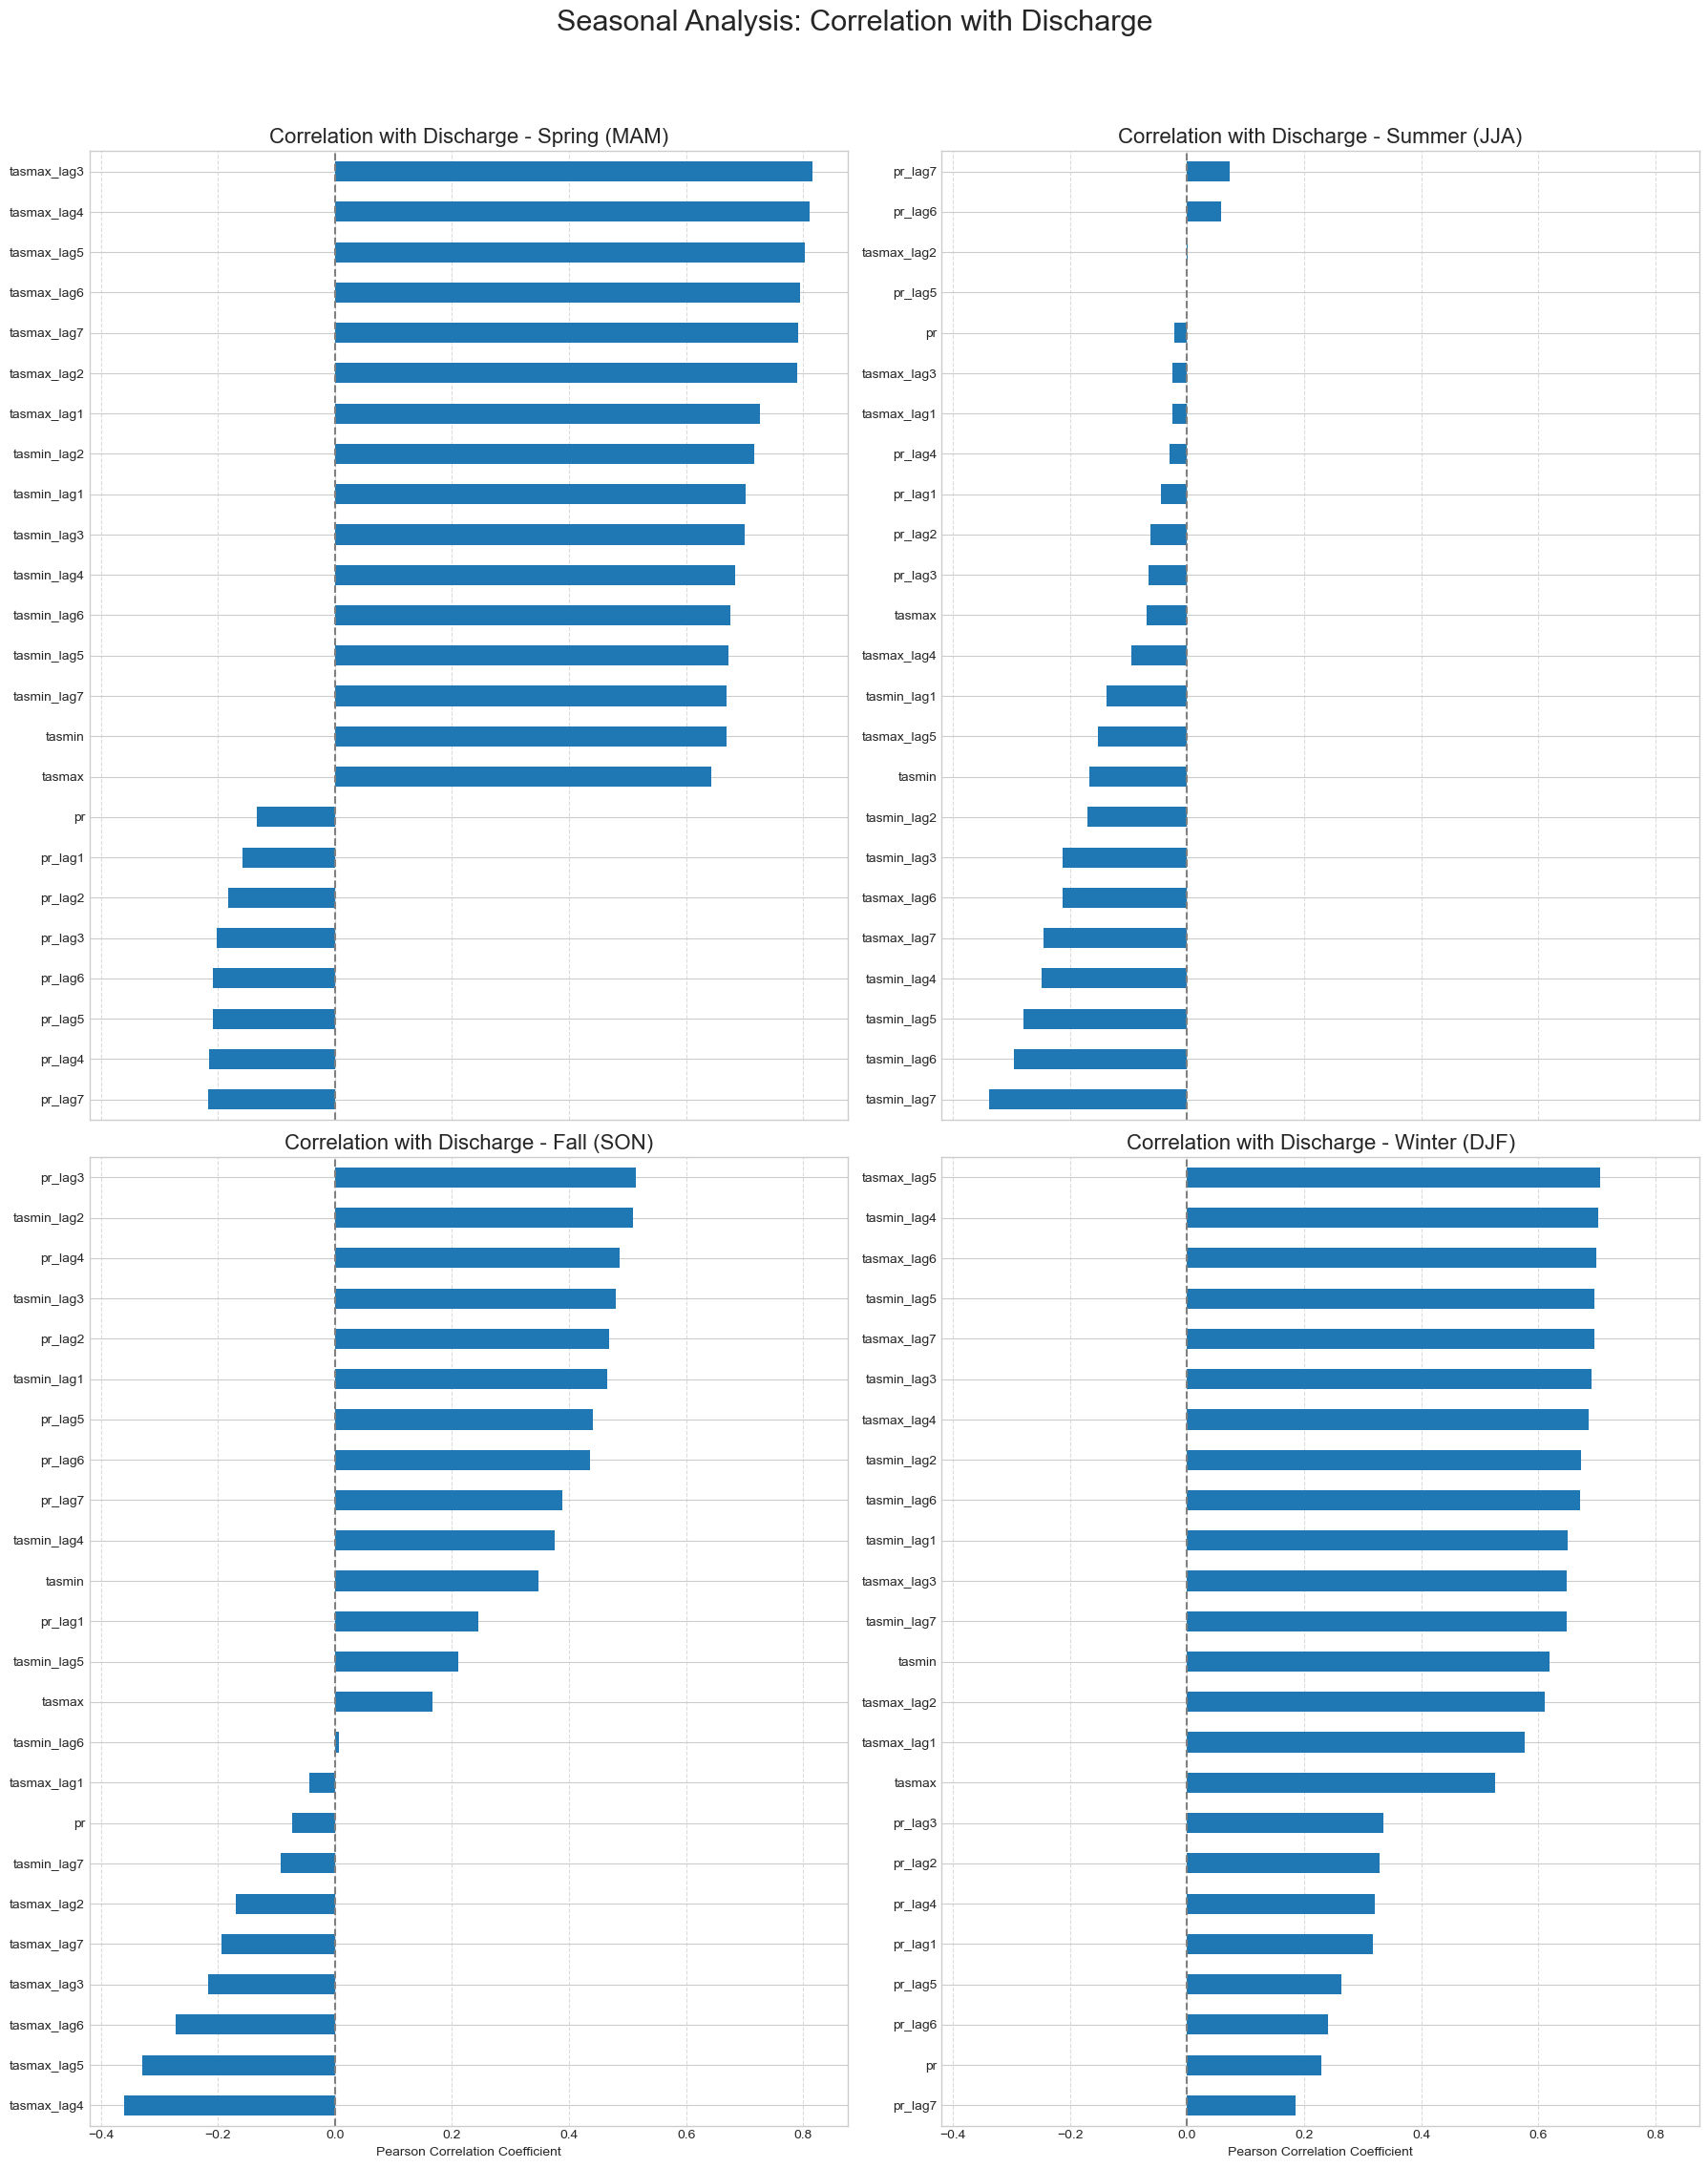

In [7]:
# --- 9. Calculate and Plot Seasonal Correlations (Corrected) ---

# Define the order for plotting
season_order = ['Spring (MAM)', 'Summer (JJA)', 'Fall (SON)', 'Winter (DJF)']

# Create a 2x2 subplot grid. sharex=True makes the x-axis consistent across all plots.
fig, axes = plt.subplots(2, 2, figsize=(18, 22), sharex=True)
# Flatten the 2x2 array of axes into a 1D array for easier looping
axes = axes.flatten()

# Loop through each season and its corresponding subplot axis
for i, season in enumerate(season_order):
    ax = axes[i]
    print(f"\n--- Analyzing {season} ---")
    
    # Filter the DataFrame for the current season
    df_season = seasonal_df[seasonal_df['Season'] == season]
    
    # --- THIS IS THE FIX ---
    # Perform correlation on NUMERIC COLUMNS ONLY, ignoring our text 'Season' column.
    corr_matrix_season = df_season.corr(numeric_only=True)
    # -----------------------
    
    discharge_corr_season = corr_matrix_season[['Discharge']].sort_values(by='Discharge', ascending=False)
    discharge_corr_season = discharge_corr_season.drop('Discharge')
    
    print(discharge_corr_season.head())
    
    # --- Plotting on the specific subplot ---
    discharge_corr_season['Discharge'].plot(kind='barh', ax=ax)
    
    ax.set_title(f'Correlation with Discharge - {season}', fontsize=16)
    ax.axvline(x=0, color='grey', linestyle='--')
    ax.set_xlabel('Pearson Correlation Coefficient')
    ax.invert_yaxis()
    ax.grid(axis='x', linestyle='--', alpha=0.7)

# Add a main title for the entire figure
plt.suptitle('Seasonal Analysis: Correlation with Discharge', fontsize=22, y=1.03)
plt.tight_layout()
plt.show()

--- Building a Simple Linear Model based on 3-Day Lagged Max Temperature ---

--- Simple Temperature Model Summary ---
                            OLS Regression Results                            
Dep. Variable:              Discharge   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                     138.5
Date:                Thu, 21 Aug 2025   Prob (F-statistic):           3.24e-26
Time:                        17:00:38   Log-Likelihood:                -1415.4
No. Observations:                 280   AIC:                             2835.
Df Residuals:                     278   BIC:                             2842.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-----------

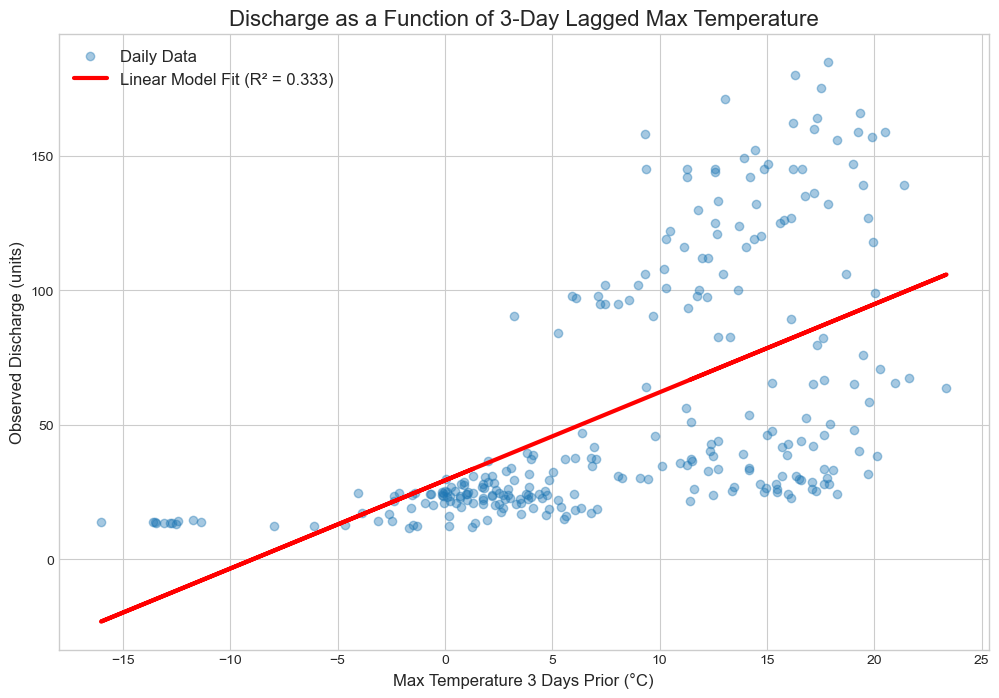

In [8]:
print("--- Building a Simple Linear Model based on 3-Day Lagged Max Temperature ---")

# --- 1. Define the Model Variables ---
# We use the 'analysis_df' from Cell 4, which is already clean and has the lags.
Y = analysis_df['Discharge']
X = analysis_df[['tasmax_lag3']] # Use double brackets to keep it as a DataFrame

# Add the constant (intercept) to the model
X = sm.add_constant(X)

# --- 2. Fit the Model ---
model_temp = sm.OLS(Y, X)
results_temp = model_temp.fit()

# --- 3. Print and Interpret the Model Summary ---
print("\n--- Simple Temperature Model Summary ---")
print(results_temp.summary())

# --- 4. Visualize the Relationship ---
# A scatter plot is perfect for visualizing a single-variable linear model.

# Get the model's predictions for the regression line
predictions = results_temp.predict(X)

plt.figure(figsize=(12, 8))
# Plot the raw data points
plt.scatter(X['tasmax_lag3'], Y, alpha=0.4, label='Daily Data')
# Plot the regression line
plt.plot(X['tasmax_lag3'], predictions, color='red', linewidth=3, 
         label=f'Linear Model Fit (R² = {results_temp.rsquared:.3f})')

plt.title('Discharge as a Function of 3-Day Lagged Max Temperature', fontsize=16)
plt.xlabel('Max Temperature 3 Days Prior (°C)', fontsize=12)
plt.ylabel('Observed Discharge (units)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

--- Starting Focused Analysis for May and June ---
Original number of observations: 280
Number of observations in May & June: 61

--- Correlation between 'tasmax_lag3' and 'Discharge' for May-June ---
Pearson Correlation Coefficient: 0.7315
For comparison, the full-year correlation was: 0.5767


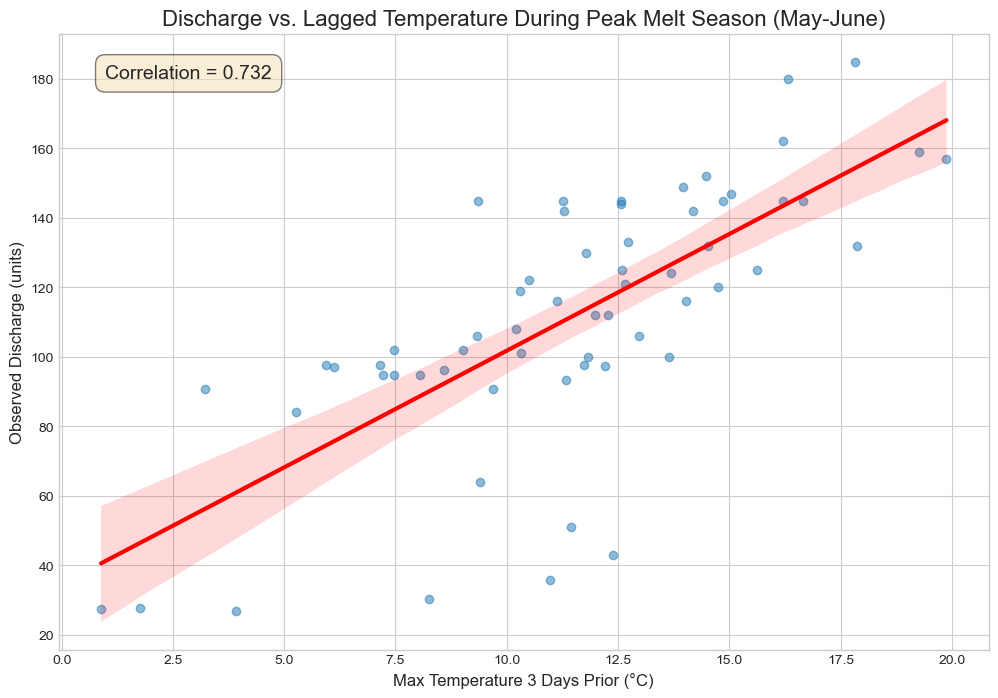

In [9]:
print("--- Starting Focused Analysis for May and June ---")

# We use 'analysis_df' from Cell 4, which has the lags and the original flow data.

# --- 1. Filter the DataFrame for May and June ---
# We can access the month from the DataFrame's DatetimeIndex.
# The .isin() method is a clean way to select rows where the month is 5 (May) or 6 (June).
melt_season_df = analysis_df[analysis_df.index.month.isin([5, 6])].copy()

print(f"Original number of observations: {len(analysis_df)}")
print(f"Number of observations in May & June: {len(melt_season_df)}")

# --- 2. Calculate the Correlation ---
# We can calculate the specific correlation directly using the .corr() method on the two series.
correlation = melt_season_df['tasmax_lag3'].corr(melt_season_df['Discharge'])

print(f"\n--- Correlation between 'tasmax_lag3' and 'Discharge' for May-June ---")
print(f"Pearson Correlation Coefficient: {correlation:.4f}")

# For context, let's compare it to the full-year correlation
full_year_correlation = analysis_df['tasmax_lag3'].corr(analysis_df['Discharge'])
print(f"For comparison, the full-year correlation was: {full_year_correlation:.4f}")

# --- 3. Visualize the Relationship ---
plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))

# sns.regplot is perfect for this as it creates a scatter plot and fits a regression line.
sns.regplot(
    x='tasmax_lag3', 
    y='Discharge', 
    data=melt_season_df,
    line_kws={'color': 'red', 'linewidth': 3}, 
    scatter_kws={'alpha': 0.5}
)

plt.title('Discharge vs. Lagged Temperature During Peak Melt Season (May-June)', fontsize=16)
plt.xlabel('Max Temperature 3 Days Prior (°C)', fontsize=12)
plt.ylabel('Observed Discharge (units)', fontsize=12)
plt.grid(True)

# Add an annotation with the correlation value
plt.text(
    0.05, 0.95, 
    f'Correlation = {correlation:.3f}',
    transform=plt.gca().transAxes, 
    fontsize=14, 
    verticalalignment='top',
    bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5)
)

plt.show()